In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
#!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
#import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 50 
VOLUME_START_AT = 22 # first slice of volume that we will include


Text(0.5, 1.0, 'Mask')

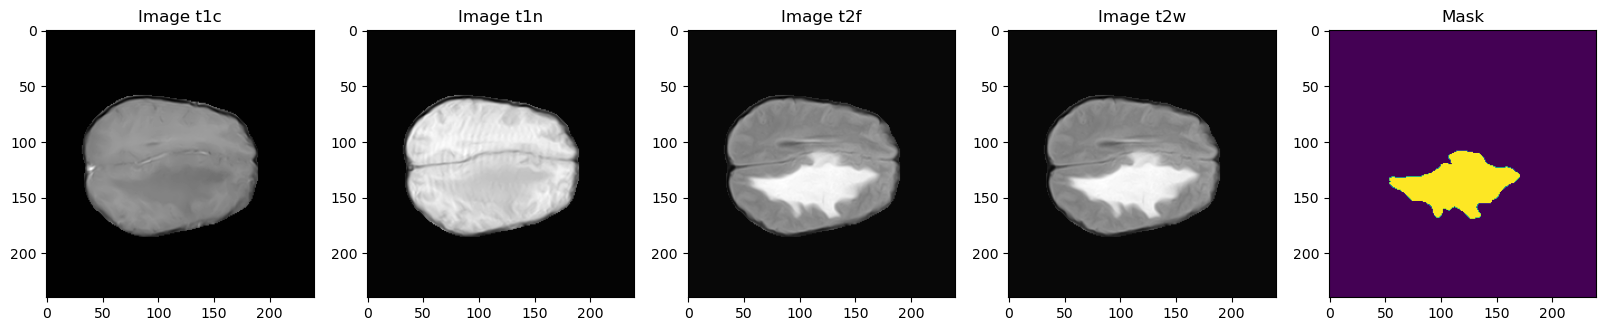

In [4]:
TRAIN_DATASET_PATH = '/kaggle/input/brats2023-ssa-training-dataset/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2/'
VALIDATION_DATASET_PATH = '../input//kaggle/input/brats2023-ssa-validation-dataset/ASNR-MICCAI-BraTS2023-SSA-Challenge-ValidationData/'

#test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1c=nib.load(TRAIN_DATASET_PATH + 'BraTS-SSA-00002-000/BraTS-SSA-00002-000-t1c.nii').get_fdata()

#test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1n=nib.load(TRAIN_DATASET_PATH + 'BraTS-SSA-00002-000/BraTS-SSA-00002-000-t1n.nii').get_fdata()

#test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2f=nib.load(TRAIN_DATASET_PATH + 'BraTS-SSA-00002-000/BraTS-SSA-00002-000-t2f.nii').get_fdata()

#test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_image_t2w=nib.load(TRAIN_DATASET_PATH + 'BraTS-SSA-00002-000/BraTS-SSA-00002-000-t2f.nii').get_fdata()

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS-SSA-00002-000/BraTS-SSA-00002-000-seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_t1c[:,:,test_image_t1c.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image t1c')
ax2.imshow(test_image_t1n[:,:,test_image_t1n.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1n')
ax3.imshow(test_image_t2f[:,:,test_image_t2f.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t2f')
ax4.imshow(test_image_t2w[:,:,test_image_t2w.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2w')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

In [5]:
test_image_t2w.shape

(240, 240, 155)

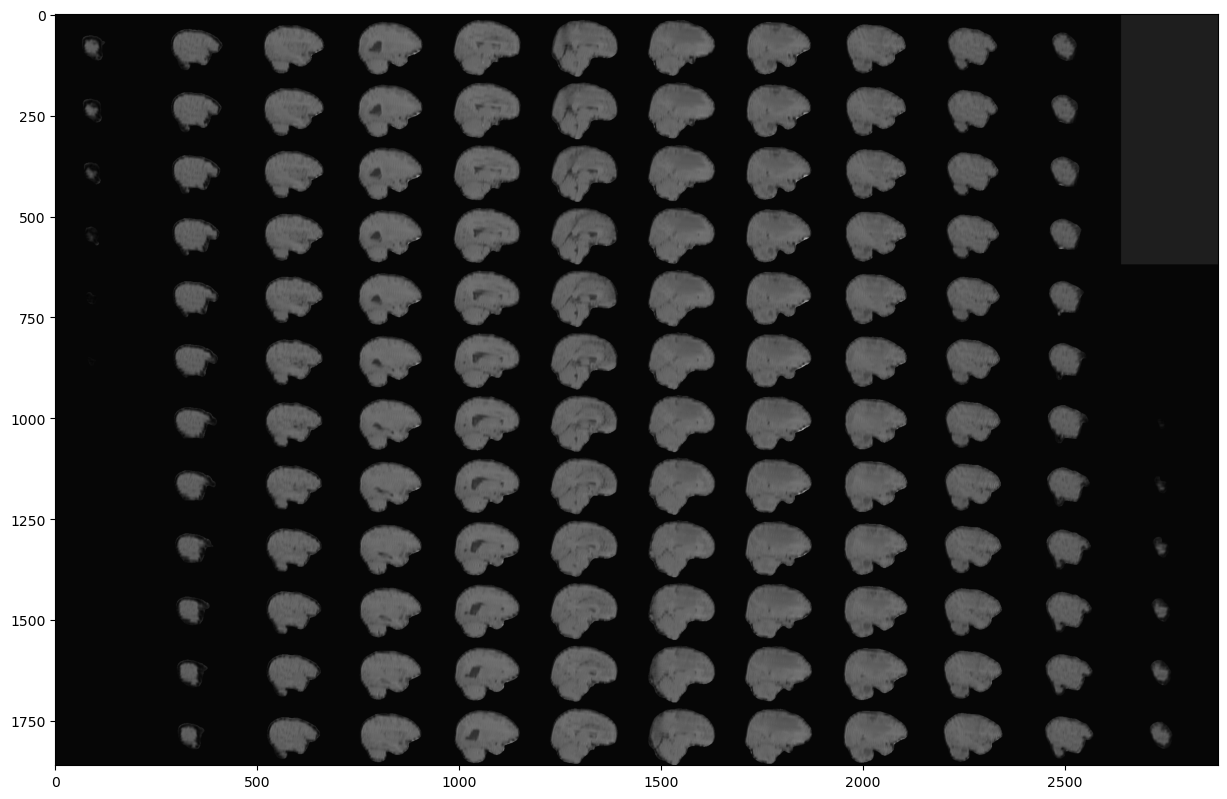

In [6]:
#Show whole nifti data -> print each slice from 3d data
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1n[50:-50,:,:]), 90, resize=True), cmap ='gray')

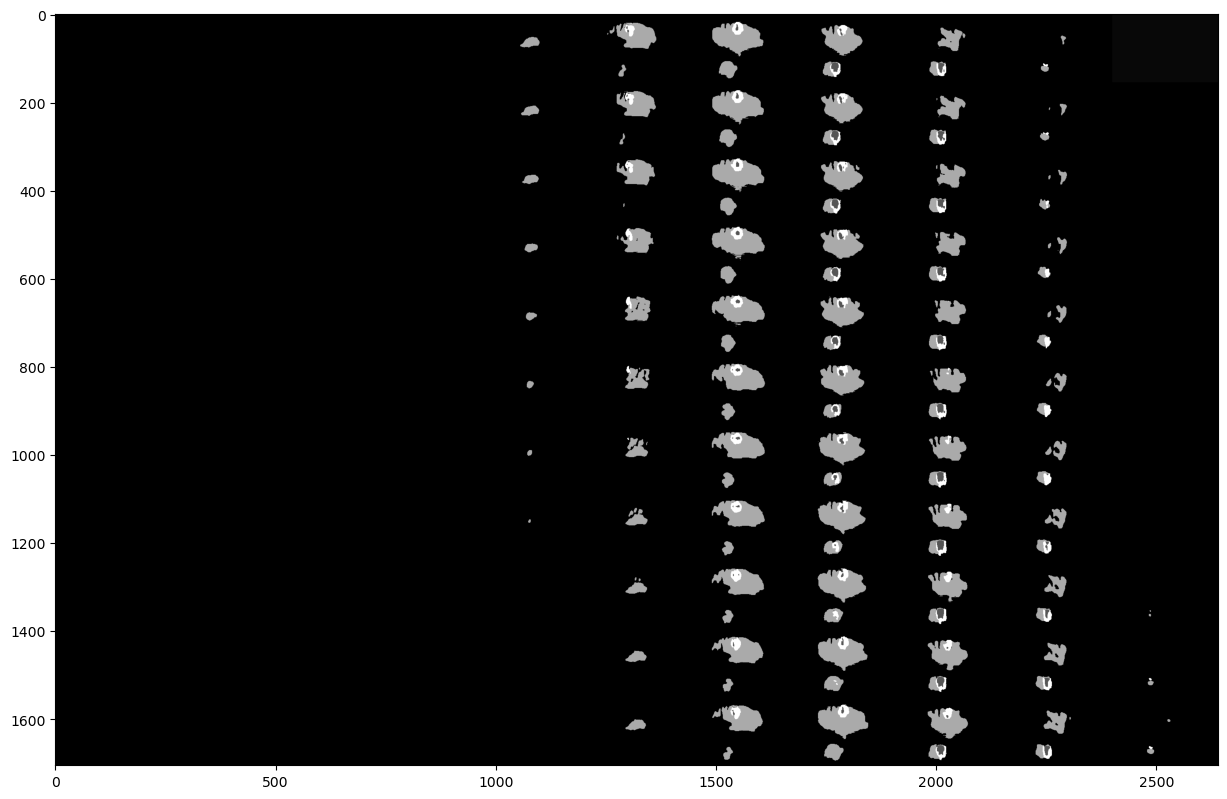

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

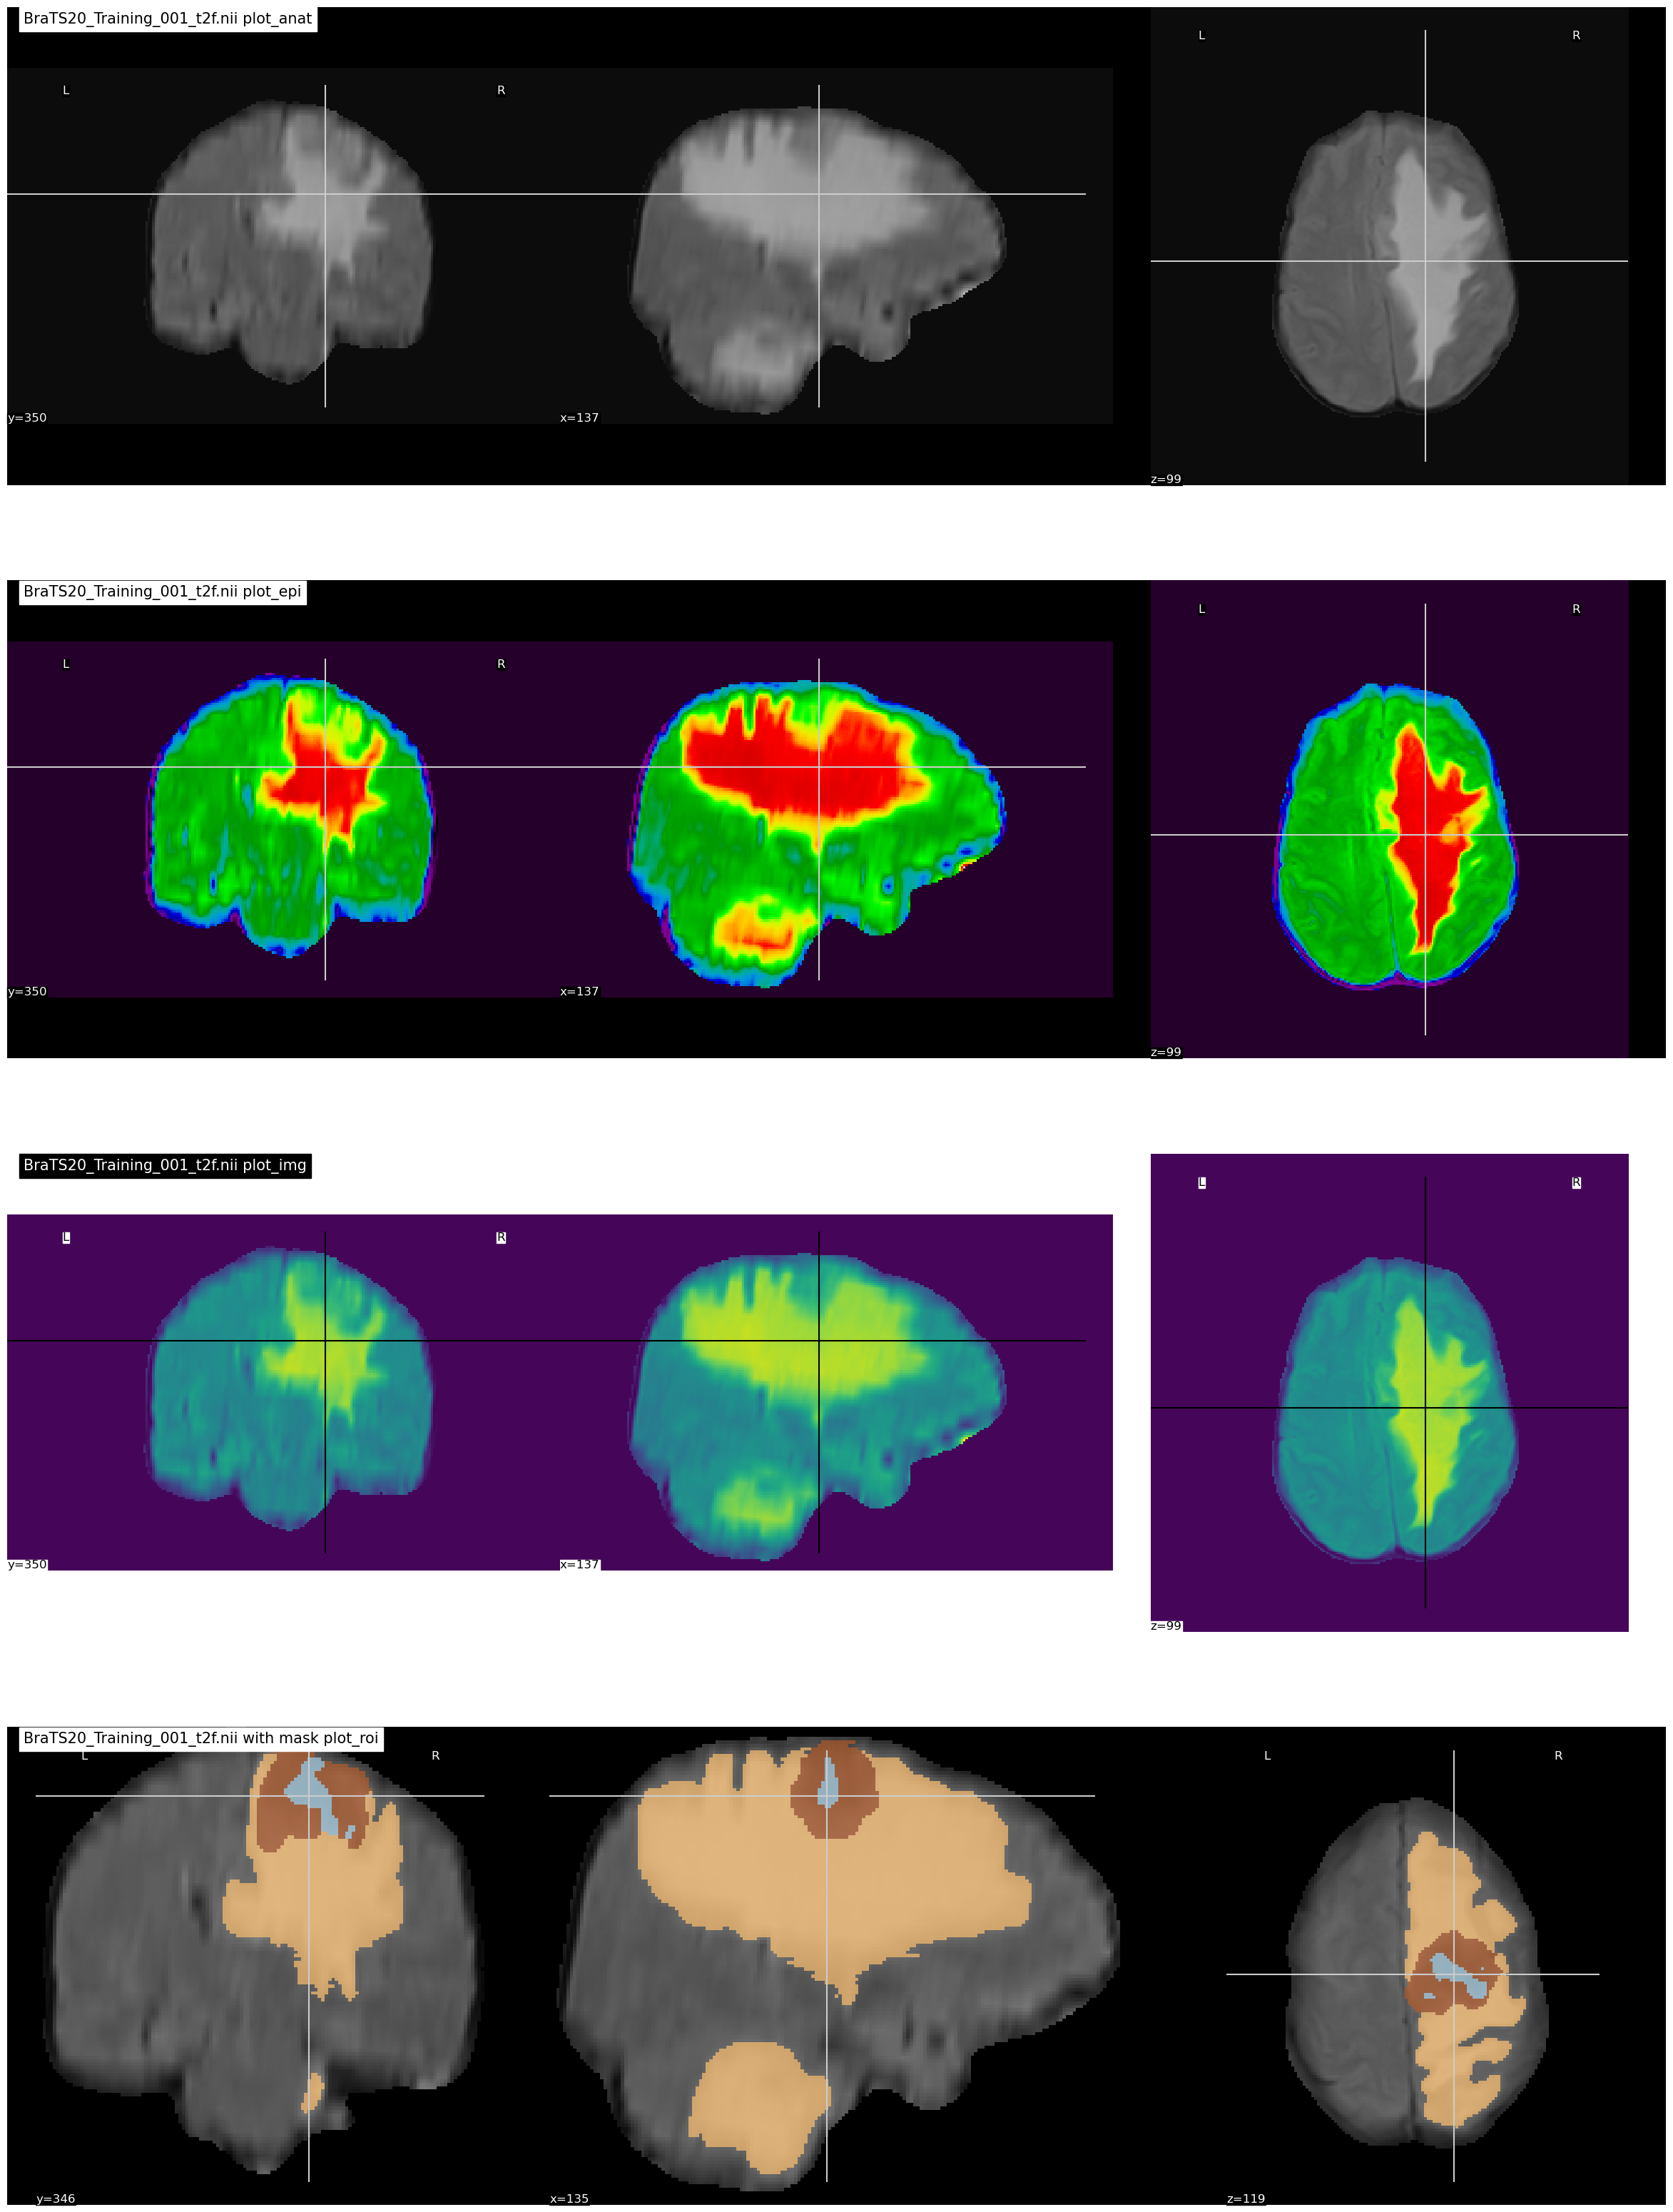

In [8]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS-SSA-00002-000/BraTS-SSA-00002-000-t2f.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS-SSA-00002-000/BraTS-SSA-00002-000-seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_t2f.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_t2f.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_t2f.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_t2f.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [10]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


In [11]:
IMG_SIZE=128

In [ ]:
from keras.layers import Conv3D, MaxPooling3D, UpSampling3D, concatenate

def build_unet(inputs, ker_init, dropout):
    conv1 = Conv3D(16, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Dropout(0.1)(conv1)

    pool = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    conv = Conv3D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool)
    conv = Dropout(0.2)(conv)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv)
    conv2 = Conv3D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Dropout(0.1)(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    conv3 = Conv3D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Dropout(0.2)(conv3)

    up8 = Conv3D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(conv3))
    merge8 = concatenate([conv2, up8], axis=4)
    conv8 = Conv3D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = Dropout(0.1)(conv8)

    up9 = Conv3D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(conv8))
    merge9 = concatenate([conv, up9], axis=4)
    conv9 = Conv3D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = Dropout(0.2)(conv9)
    up = Conv3D(16, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(conv9))
    merge = concatenate([conv1, up], axis=4)
    conv = Conv3D(16, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge)
    conv = Dropout(0.1)(conv)
    conv10 = Conv3D(4, (1, 1, 1), activation='softmax')(conv)

    return Model(inputs=inputs, outputs=conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, IMG_DEPTH, 2))  # Assuming IMG_DEPTH is the third dimension size

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])


In [ ]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [16]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]


In [17]:
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [19]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)
            #print(case_path)

            data_path = os.path.join(case_path, f'{i}-t1c.nii');
            #print(data_path)
            flair = nib.load(data_path).get_fdata()
            

            data_path = os.path.join(case_path, f'{i}-t2f.nii');
            #print(data_path)
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}-seg.nii');
            #print(data_path)
            seg = nib.load(data_path).get_fdata()
            
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)


In [26]:
print(training_generator)

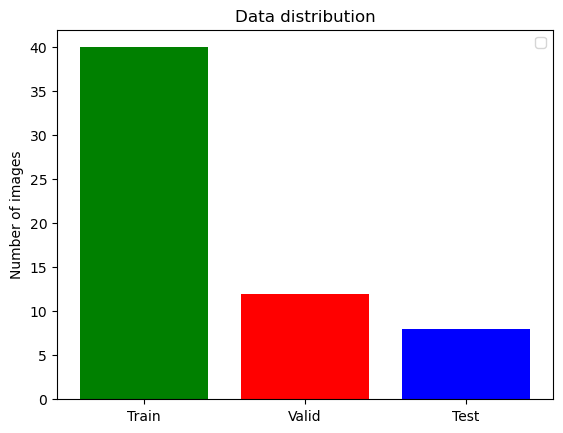

In [20]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [24]:
#K.clear_session()
history =  model.fit(training_generator,
                     epochs=20,
                     steps_per_epoch=len(train_ids),
                     callbacks= callbacks,
                     validation_data = valid_generator
                     )  
model.save("model_x1_1.h5")

Epoch 1/20
40/40 [==============================] - 27s 688ms/step - loss: 0.3105 - accuracy: 0.9776 - mean_io_u_1: 0.4700 - dice_coef: 0.2377 - precision: 0.9754 - sensitivity: 0.8771 - specificity: 0.9928 - dice_coef_necrotic: 0.0012 - dice_coef_edema: 0.0440 - dice_coef_enhancing: 0.0080 - val_loss: 0.0859 - val_accuracy: 0.9877 - val_mean_io_u_1: 0.4787 - val_dice_coef: 0.2512 - val_precision: 0.9876 - val_sensitivity: 0.9859 - val_specificity: 0.9959 - val_dice_coef_necrotic: 0.0050 - val_dice_coef_edema: 0.0503 - val_dice_coef_enhancing: 0.0038 - lr: 1.0000e-04
Epoch 2/20
40/40 [==============================] - 9s 215ms/step - loss: 0.1789 - accuracy: 0.9806 - mean_io_u_1: 0.5752 - dice_coef: 0.2533 - precision: 0.9814 - sensitivity: 0.9789 - specificity: 0.9938 - dice_coef_necrotic: 0.0052 - dice_coef_edema: 0.0362 - dice_coef_enhancing: 0.0098 - val_loss: 0.1115 - val_accuracy: 0.9877 - val_mean_io_u_1: 0.4240 - val_dice_coef: 0.2469 - val_precision: 0.9877 - val_sensitivity: 

In [22]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

KeyError: 'mean_io_u'

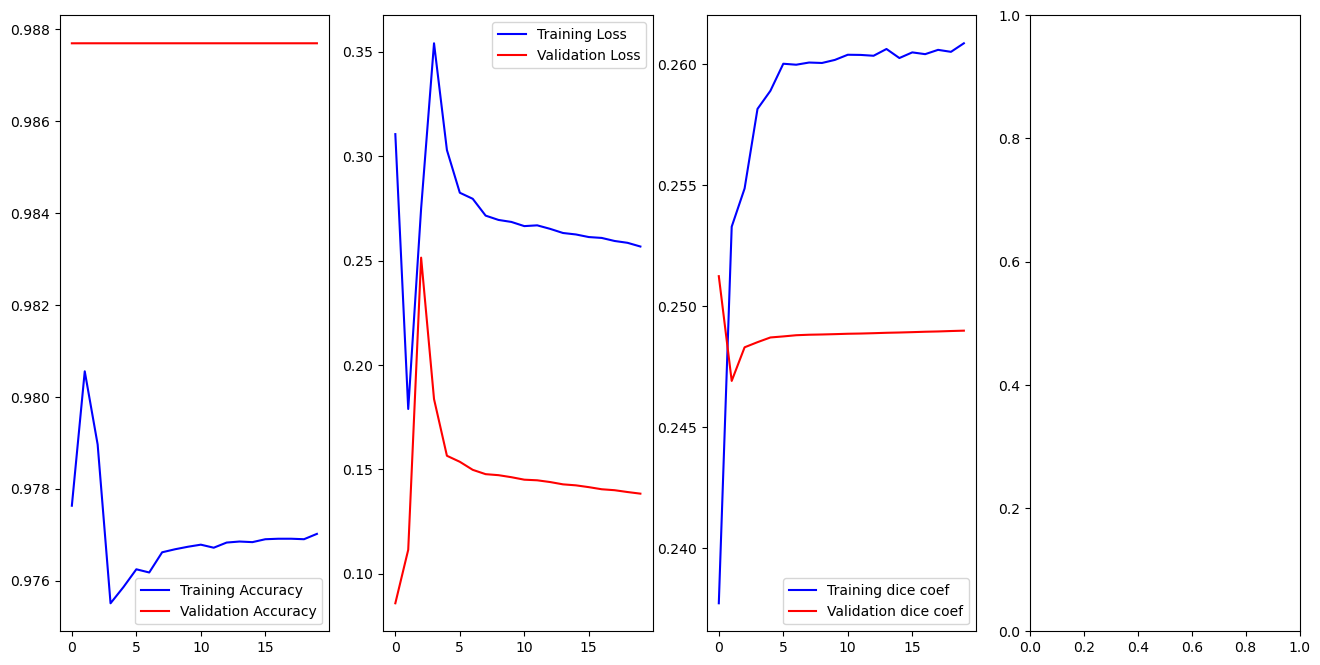

In [25]:
############ load trained model ################
model = keras.models.load_model('/kaggle/working/model_x1_1.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('/kaggle/working/training.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [26]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')
        
#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)


00051
2/2 [==============================] - 1s 359ms/step


<Figure size 1800x5000 with 0 Axes>

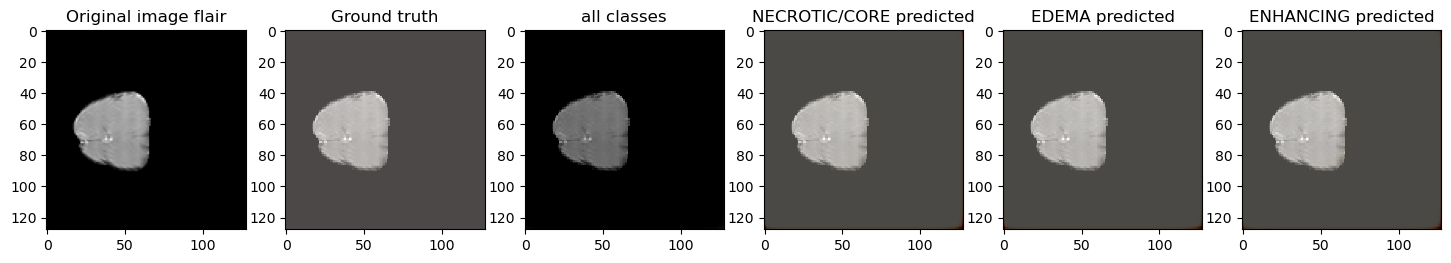

00015
2/2 [==============================] - 0s 15ms/step


<Figure size 1800x5000 with 0 Axes>

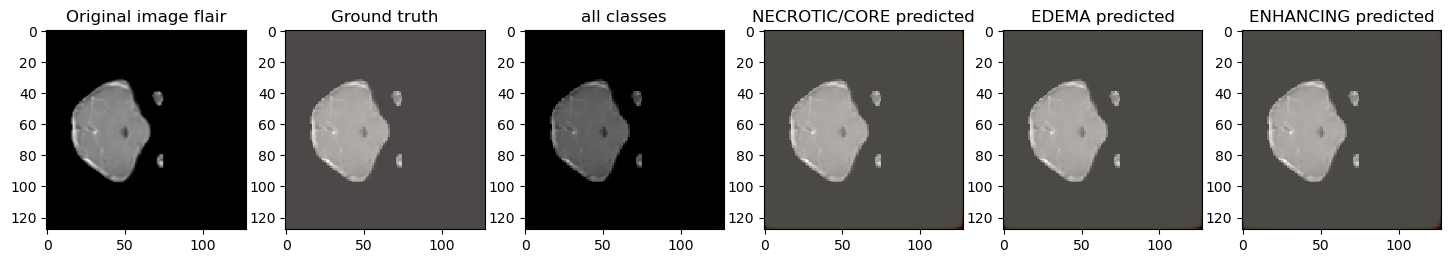

00133
2/2 [==============================] - 0s 15ms/step


<Figure size 1800x5000 with 0 Axes>

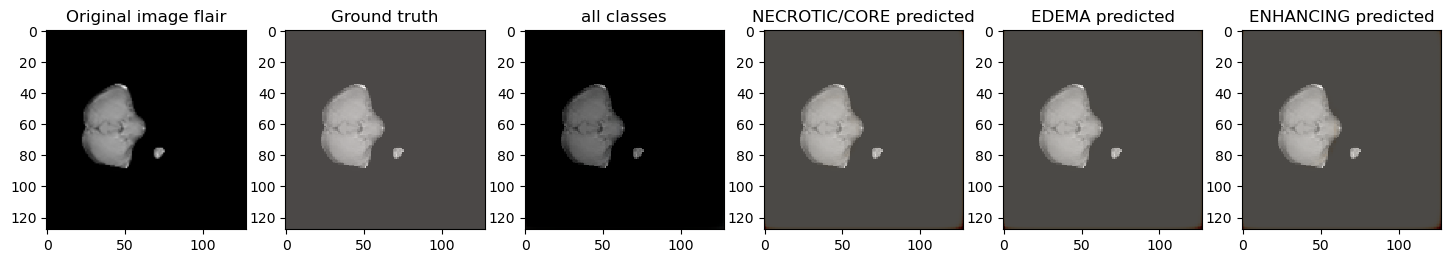

00110
2/2 [==============================] - 0s 15ms/step


<Figure size 1800x5000 with 0 Axes>

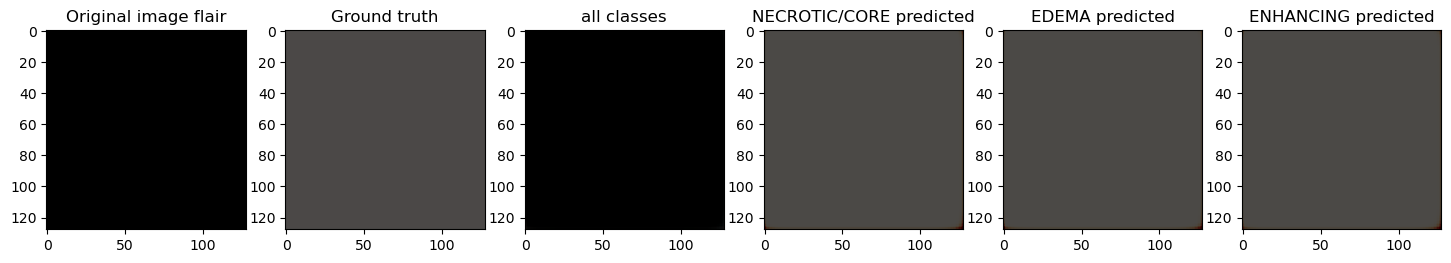

00213
2/2 [==============================] - 0s 15ms/step


<Figure size 1800x5000 with 0 Axes>

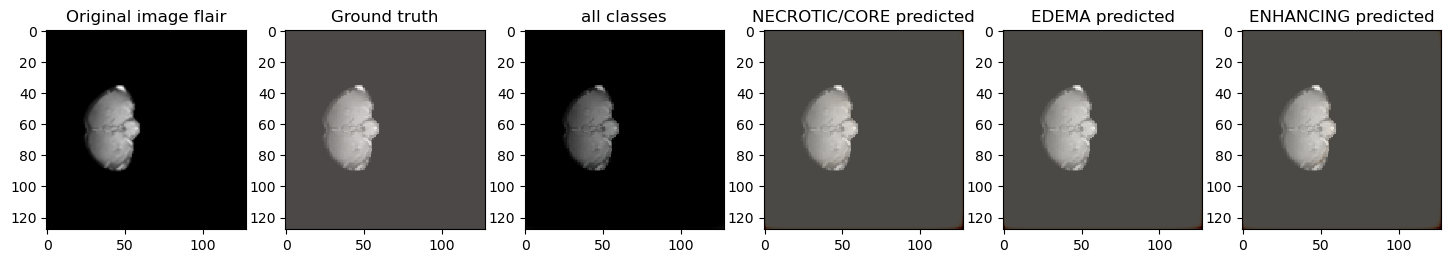

00080
2/2 [==============================] - 0s 15ms/step


<Figure size 1800x5000 with 0 Axes>

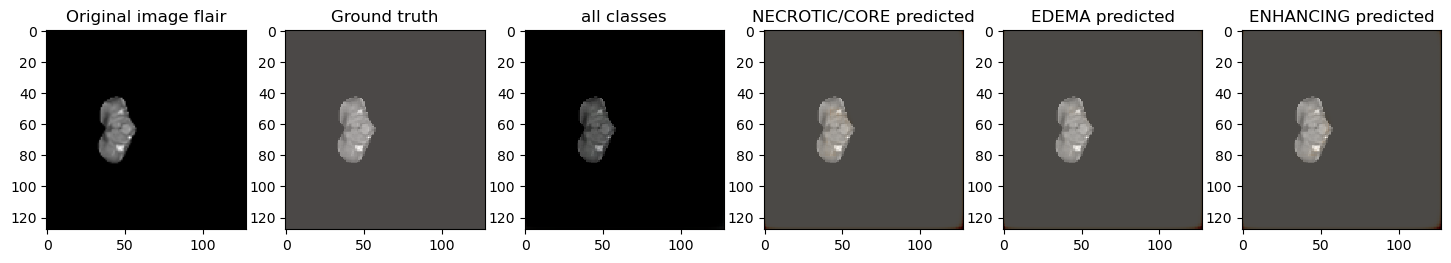

00215
2/2 [==============================] - 0s 15ms/step


<Figure size 1800x5000 with 0 Axes>

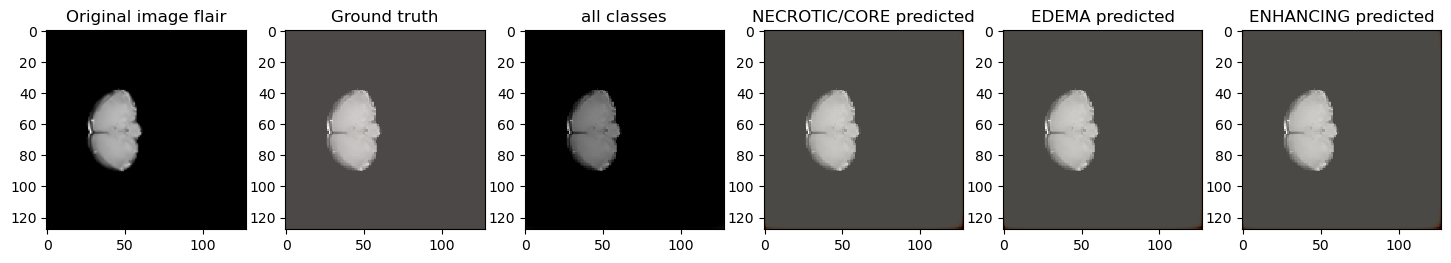

In [27]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    print(case)
    vol_path = os.path.join(case_path, f'BraTS-SSA-{case}-000-t1c.nii');
    
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS-SSA-{case}-000-t2f.nii');
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"/kaggle/input/brats2023-ssa-training-dataset/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2/BraTS-SSA-{case}-000"
    gt = nib.load(os.path.join(path, f'BraTS-SSA-{case}-000-seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS-SSA-{case}-000-t1c.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
    
showPredictsById(case=test_ids[0][-9:-4], start_slice=5)
showPredictsById(case=test_ids[1][-9:-4], start_slice=5)
showPredictsById(case=test_ids[2][-9:-4], start_slice=5)
showPredictsById(case=test_ids[3][-9:-4], start_slice=5)
showPredictsById(case=test_ids[4][-9:-4], start_slice=5)
showPredictsById(case=test_ids[5][-9:-4], start_slice=5)
showPredictsById(case=test_ids[6][-9:-4], start_slice=5)



# mask = np.zeros((10,10))
# mask[3:-3, 3:-3] = 1 # white square in black background
# im = mask + np.random.randn(10,10) * 0.01 # random image
# masked = np.ma.masked_where(mask == 0, mask)

# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(im, 'gray', interpolation='none')
# plt.subplot(1,2,2)
# plt.imshow(im, 'gray', interpolation='none')
# plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
# plt.show()

00051
2/2 [==============================] - 0s 15ms/step


<Figure size 1800x5000 with 0 Axes>

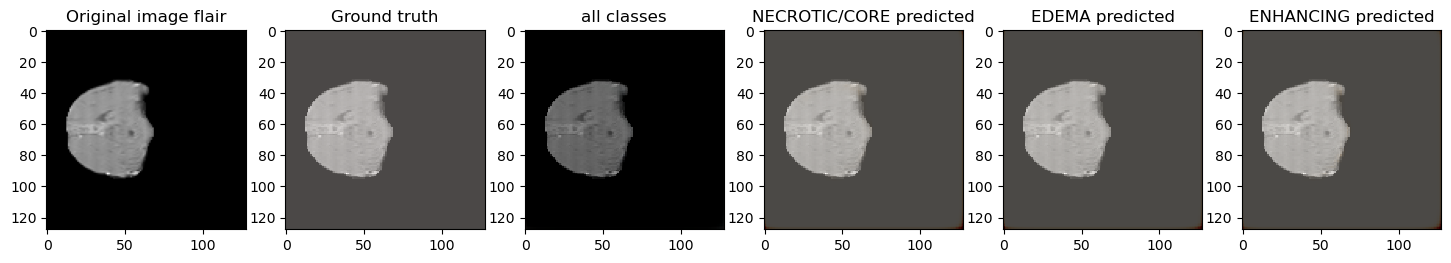

00015
2/2 [==============================] - 0s 15ms/step


<Figure size 1800x5000 with 0 Axes>

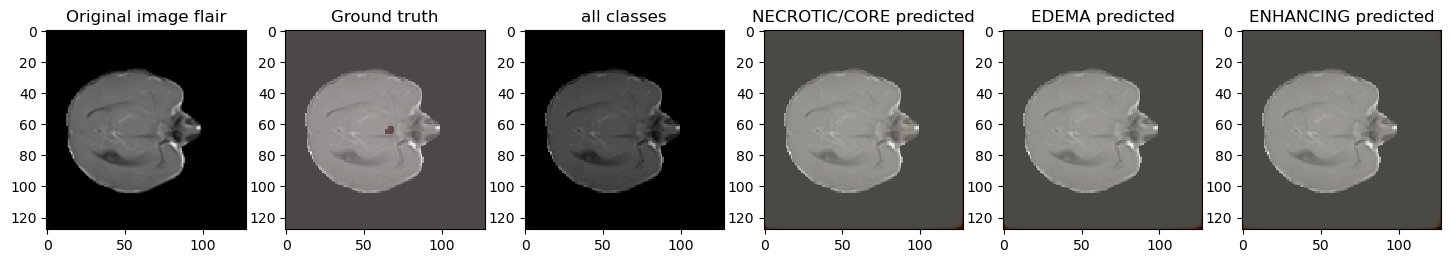

00133
2/2 [==============================] - 0s 16ms/step


<Figure size 1800x5000 with 0 Axes>

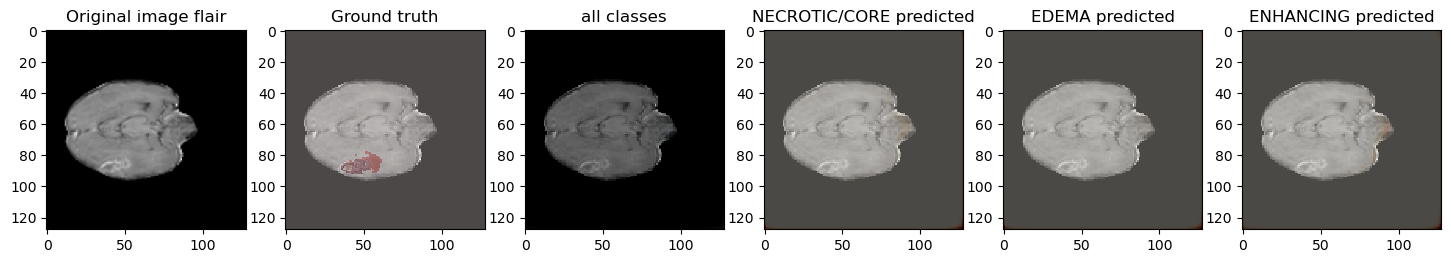

00110
2/2 [==============================] - 0s 15ms/step


<Figure size 1800x5000 with 0 Axes>

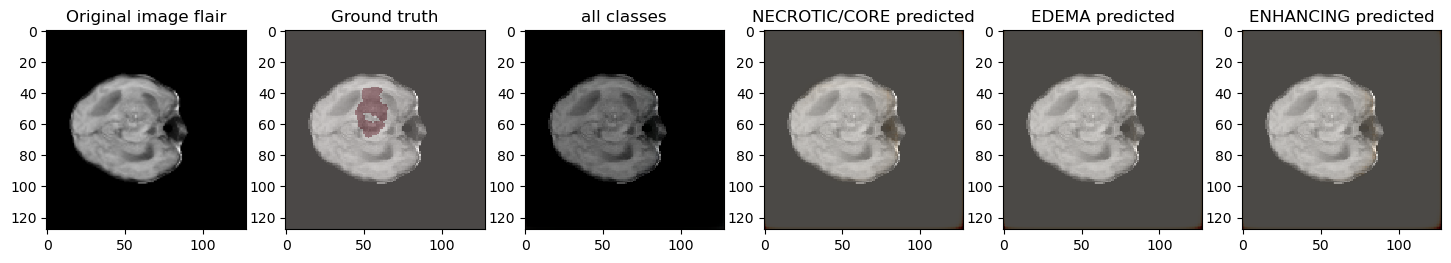

00213
2/2 [==============================] - 0s 15ms/step


<Figure size 1800x5000 with 0 Axes>

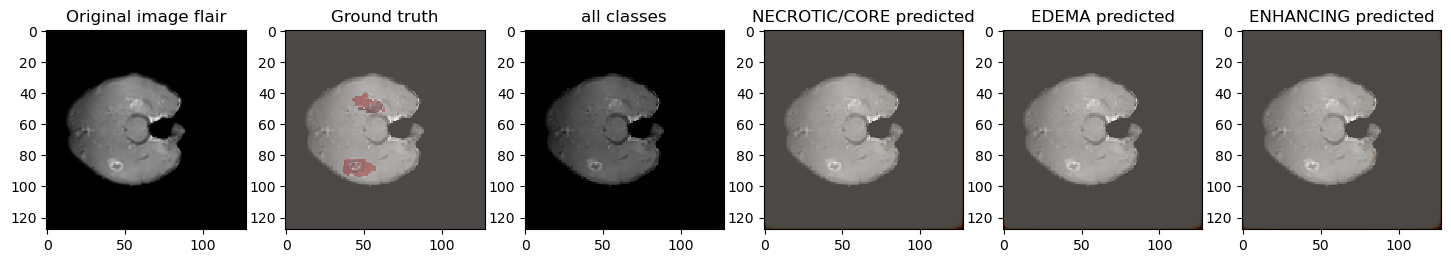

00080
2/2 [==============================] - 0s 15ms/step


<Figure size 1800x5000 with 0 Axes>

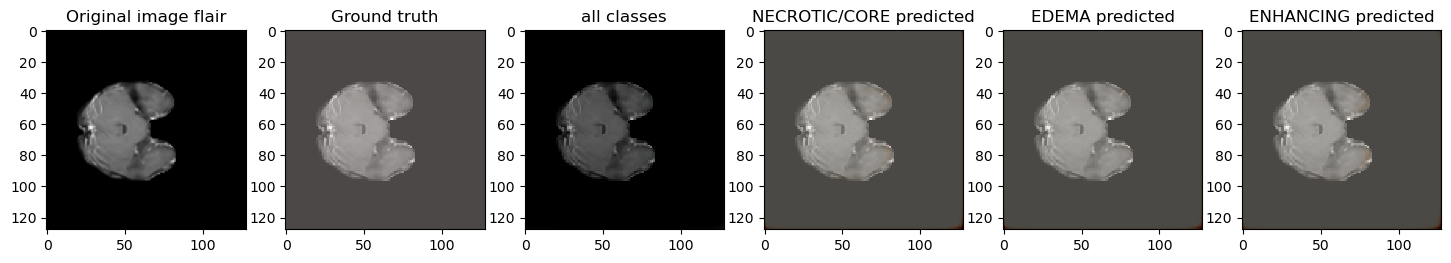

00215
2/2 [==============================] - 0s 15ms/step


<Figure size 1800x5000 with 0 Axes>

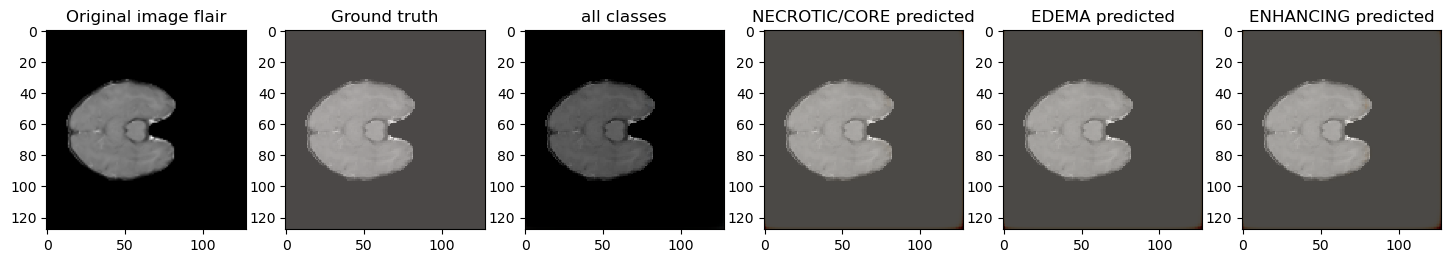

In [28]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    print(case)
    vol_path = os.path.join(case_path, f'BraTS-SSA-{case}-000-t1c.nii');
    
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS-SSA-{case}-000-t2f.nii');
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"/kaggle/input/brats2023-ssa-training-dataset/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2/BraTS-SSA-{case}-000"
    gt = nib.load(os.path.join(path, f'BraTS-SSA-{case}-000-seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS-SSA-{case}-000-t1c.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
    
showPredictsById(case=test_ids[0][-9:-4], start_slice=30)
showPredictsById(case=test_ids[1][-9:-4], start_slice=30)
showPredictsById(case=test_ids[2][-9:-4], start_slice=30)
showPredictsById(case=test_ids[3][-9:-4], start_slice=30)
showPredictsById(case=test_ids[4][-9:-4], start_slice=30)
showPredictsById(case=test_ids[5][-9:-4], start_slice=30)
showPredictsById(case=test_ids[6][-9:-4], start_slice=30)



# mask = np.zeros((10,10))
# mask[3:-3, 3:-3] = 1 # white square in black background
# im = mask + np.random.randn(10,10) * 0.01 # random image
# masked = np.ma.masked_where(mask == 0, mask)

# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(im, 'gray', interpolation='none')
# plt.subplot(1,2,2)
# plt.imshow(im, 'gray', interpolation='none')
# plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
# plt.show()

In [100]:
test_ids[0][-9:-4]


'00076'

['BraTS-SSA-00076-000',
 'BraTS-SSA-00010-000',
 'BraTS-SSA-00093-000',
 'BraTS-SSA-00015-000',
 'BraTS-SSA-00150-000',
 'BraTS-SSA-00095-000',
 'BraTS-SSA-00135-000',
 'BraTS-SSA-00133-000']

00051
00051
2/2 [==============================] - 0s 15ms/step


<Figure size 640x480 with 0 Axes>

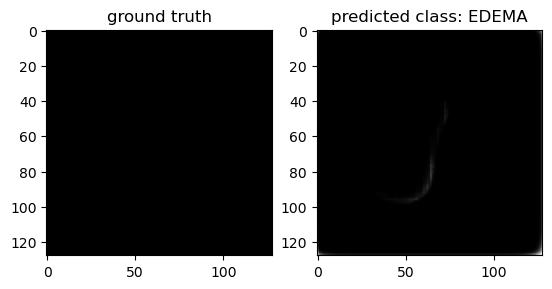

In [30]:
case = case=test_ids[0][-9:-4]
print(case)


path = f"/kaggle/input/brats2023-ssa-training-dataset/ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2/BraTS-SSA-{case}-000"
gt = nib.load(os.path.join(path, f'BraTS-SSA-{case}-000-seg.nii')).get_fdata()
p = predictByPath(path,case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



gt[gt != eval_class] = 1 # use only one class for per class evaluation 

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [31]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 4s 360ms/step - loss: 0.1429 - accuracy: 0.9898 - mean_io_u_3: 0.6978 - dice_coef: 0.2489 - precision: 0.9898 - sensitivity: 0.9895 - specificity: 0.9966 - dice_coef_necrotic: 8.7298e-08 - dice_coef_edema: 2.6655e-04 - dice_coef_enhancing: 1.3337e-04
test loss, test acc: [0.14288188517093658, 0.9897834658622742, 0.6977821588516235, 0.2488834708929062, 0.9897785186767578, 0.9894847273826599, 0.9965938925743103, 8.729836054044426e-08, 0.0002665542415343225, 0.00013337352720554918]
